In [1]:
# sensor area 8.45 x 7.07 mm^3 (Genie Nano C2420 Color)
# resolution 2448 x 2,048 pix
pixel_mm = 2448 / 8.45
noise_mm = 30 / pixel_mm # +/- 30pix
# lens
model = 'equidistant'
# model = 'stereographic'
# model = 'orthographic'
# model = 'equisolid'
focal_length = 2.7

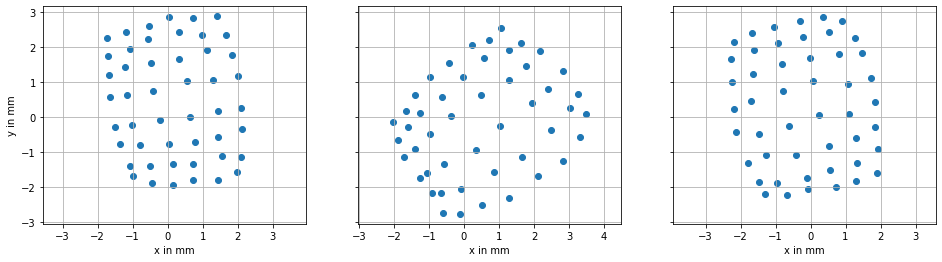

In [2]:
# random data
from omnicalib_tests import get_data
R, T, world_points, _, image_points = get_data(focal_length, model, 9, noise=noise_mm)
image_points += image_points.new_empty(2).uniform_(-30, 30) / pixel_mm # +/- 30pix

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 4)
fig, ax = plt.subplots(1, 3, sharey=True)
for a, ip in zip(ax, image_points):
    a.scatter(ip[:, 0], ip[:, 1])
    a.grid(True)
    a.axis('equal')
    a.set_xlabel('x in mm')
    if a is ax[0]:
        a.set_ylabel('y in mm')
    

INFO:calibrate:Brute-force search for principal point (3 images with mean reprojection error <= 0.2)
0.204   +0   +0:   0%|                                                                                                                                                                | 0/397 [00:00<?, ?it/s]
INFO:calibrate:Valid solution for 3/9 images
INFO:calibrate:Initial reprojection error $\mu=1.0\mathrm{e}{-1}, \sigma=1.5\mathrm{e}{-2}$
INFO:calibrate:Initial principal point (0.0, 0.0)
INFO:calibrate:Initial solution for 3/3 valid


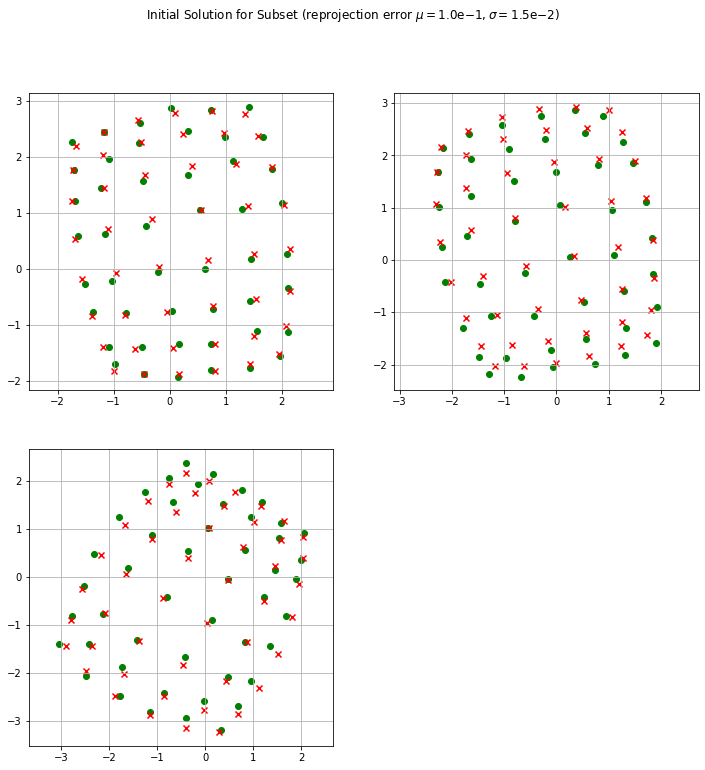

rmse 5.640e-02: : 19it [00:01, 17.54it/s] 
INFO:calibrate:Optimized reprojection error $\mu=7.3\mathrm{e}{-2}, \sigma=3.2\mathrm{e}{-2}$
INFO:calibrate:Optimized principal point (0.1, 0.1)


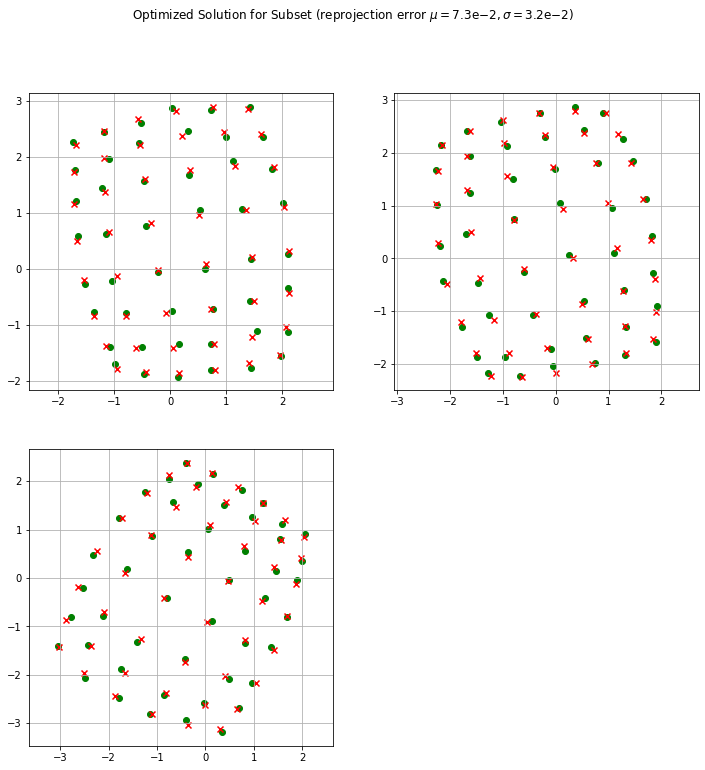

rmse 5.637e-02: : 15it [00:03,  4.71it/s]
INFO:calibrate:Final reprojection error $\mu=7.3\mathrm{e}{-2}, \sigma=3.2\mathrm{e}{-2}$
INFO:calibrate:Final principal point (0.1, 0.1)


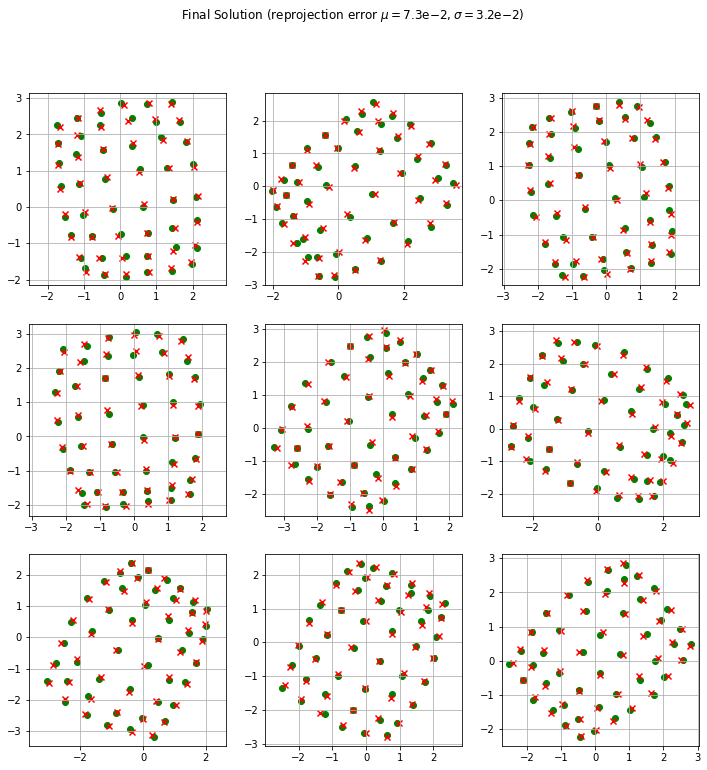

In [3]:
# calibration
degree = 3
reprojection_error_threshold = 50 / pixel_mm
reprojection_count = 3
plt.rcParams["figure.figsize"] = (16, 16)
from omnicalib.calibrate import calibrate
R_c, T_c, poly_theta, poly, principal_point = calibrate(degree, reprojection_error_threshold, reprojection_count, image_points, world_points, image_points.new_zeros(2), True)

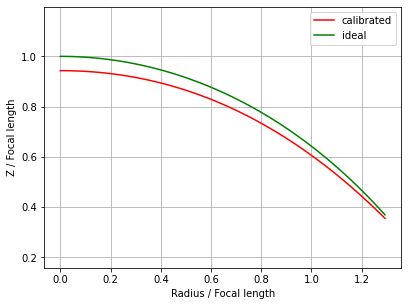

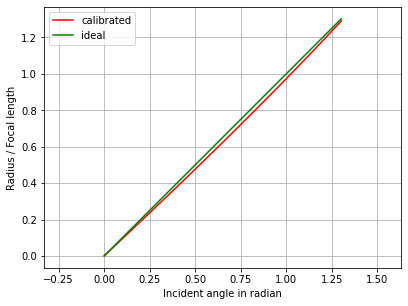

In [4]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']
import torch
from omnicalib.plot import plot_rz_curve, plot_thetar_curve
from omnicalib.polyfit import polyval
r_max = torch.linalg.norm(image_points, dim=-1).max()
def f_z_ideal(r):
    from omnicalib.simulation import theta_ideal
    r = r + 1e-9 # not valid for r = 0
    return r / torch.tan(theta_ideal(r, focal_length, model))
fig = plot_rz_curve(r_max, poly, focal_length, xlabel='Radius / Focal length', ylabel='Z / Focal length', f_ideal=f_z_ideal)
z = polyval(r_max, poly)
def f_r_ideal(theta):
    from omnicalib.simulation import r_ideal
    return r_ideal(theta, focal_length, model)
fig = plot_thetar_curve(torch.arctan(r_max / z), poly_theta, focal_length, ylabel='Radius / Focal length', f_ideal=f_r_ideal)

In [5]:
# translation error (in mm)
torch.linalg.norm(T - T_c, dim=-1)

tensor([21.5973, 18.4128, 18.9726, 16.9167, 17.9097, 16.1647, 15.3726, 16.8225,
        17.5034], dtype=torch.float64)

In [6]:
# rotation error (frobenius norm of rotation matrix difference)
torch.linalg.norm(R - R_c, dim=(-2, -1))

tensor([0.0439, 0.0524, 0.0399, 0.0200, 0.0383, 0.0223, 0.0167, 0.0203, 0.0342],
       dtype=torch.float64)